In [2]:
import datumaro as dm

dataset_dir = "/kaggle/input/emotion-detection-fer"
formats = dm.Dataset.detect(dataset_dir)
print(f"Detected data format is '{formats}'")

dataset = dm.Dataset.import_from(dataset_dir, formats)
print(dataset)

Detected data format is 'imagenet_with_subset_dirs'
Dataset
	size=35887
	source_path=/kaggle/input/emotion-detection-fer
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.label: 1>}
	annotated_items_count=35887
	annotations_count=35887
subsets
	test: # of items=7178, # of annotated items=7178, # of annotations=7178
	train: # of items=28709, # of annotated items=28709, # of annotations=28709
infos
	categories
	label: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']



In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc  # Garbage collector

# Clear any existing models from memory
tf.keras.backend.clear_session()
gc.collect()

# Define constants with smaller values
IMG_HEIGHT = 96  # Reduced from 224
IMG_WIDTH = 96
BATCH_SIZE = 16  # Reduced from 32
EPOCHS = 20
NUM_CLASSES = 7

# Paths
TRAIN_DIR = '/kaggle/input/emotion-detection-fer/train'
TEST_DIR = '/kaggle/input/emotion-detection-fer/test'


In [4]:
# Data Augmentation for training with minimal preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

# Simple rescaling for validation/test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and prepare the training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

# Load and prepare the test data
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
def create_efficient_model():
    # Load MobileNetV2 with reduced input size
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        alpha=0.75  # Reduced width multiplier for even fewer parameters
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add lightweight custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # Reduced from 512
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

# Create and compile the model
model, base_model = create_efficient_model()


5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Compile with mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [7]:
# Create and compile the model
model, base_model = create_efficient_model()

# Compile with mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)


In [9]:
# Training with memory cleanup between phases
print("Phase 1: Training with frozen layers...")
history1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr])


Phase 1: Training with frozen layers...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730136219.264937     138 service.cc:145] XLA service 0x788864001be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730136219.265007     138 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730136219.265014     138 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1795 ━━━━━━━━━━━━━━━━━━━━ 2:28 83ms/step - accuracy: 0.1424 - loss: 2.8716  

I0000 00:00:1730136227.064948     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 327s 174ms/step - accuracy: 0.2883 - loss: 1.8188 - val_accuracy: 0.3522 - val_loss: 1.6626 - learning_rate: 0.0010
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 111s 62ms/step - accuracy: 0.3526 - loss: 1.6365 - val_accuracy: 0.3423 - val_loss: 1.6556 - learning_rate: 0.0010
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 143s 62ms/step - accuracy: 0.3683 - loss: 1.6098 - val_accuracy: 0.3270 - val_loss: 1.6805 - learning_rate: 0.0010
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 112s 62ms/step - accuracy: 0.3774 - loss: 1.5894 - val_accuracy: 0.3571 - val_loss: 1.6677 - learning_rate: 0.0010
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 142s 62ms/step - accuracy: 0.3785 - loss: 1.5756 - val_accuracy: 0.3037 - val_loss: 1.6881 - learning_rate: 0.0010
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 112s 62ms/step - accuracy: 0.3902 - loss: 1.5517 - val_accuracy: 0.3601 - val_loss: 1.6329 - learning_rate: 2.0000e-04
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 116s 65ms/step - accur

In [10]:
# Clear memory
gc.collect()


17806

In [15]:
# Fine-tuning phase
print("\nPhase 2: Fine-tuning...")
# Unfreeze only the last few layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Start fine-tuning the model without the workers argument
history2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)



Phase 2: Fine-tuning...
Epoch 1/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 140s 71ms/step - accuracy: 0.3602 - loss: 1.6307 - val_accuracy: 0.3795 - val_loss: 1.5881 - learning_rate: 1.0000e-04
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 112s 62ms/step - accuracy: 0.4063 - loss: 1.5257 - val_accuracy: 0.3228 - val_loss: 1.6774 - learning_rate: 1.0000e-04
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.4225 - loss: 1.4960 - val_accuracy: 0.3848 - val_loss: 1.5724 - learning_rate: 1.0000e-04
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 112s 62ms/step - accuracy: 0.4360 - loss: 1.4762 - val_accuracy: 0.3442 - val_loss: 1.6553 - learning_rate: 1.0000e-04
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 116s 64ms/step - accuracy: 0.4475 - loss: 1.4497 - val_accuracy: 0.4188 - val_loss: 1.4982 - learning_rate: 1.0000e-04
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 112s 62ms/step - accuracy: 0.4601 - loss: 1.4266 - val_accuracy: 0.3944 - val_loss: 1.5203 - learning_rate: 1.0000e-04
Epoch 7/1

In [17]:
# Combine histories
history = {}
for key in history1.history:
    history[key] = history1.history[key] + history2.history[key]

# Evaluate the model
print("\nEvaluating model...")
test_loss, test_accuracy = model.evaluate(
    test_generator)
print(f"\nTest accuracy: {test_accuracy:.4f}")



Evaluating model...
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3311 - loss: 1.6029

Test accuracy: 0.4480


In [18]:
# Generate predictions in smaller batches
print("\nGenerating predictions...")
predictions = []
batch_size = 8  # Even smaller batch size for predictions
steps = len(test_generator)
for i in range(steps):
    batch_images = next(test_generator)[0]
    batch_pred = model.predict(batch_images, verbose=0)
    predictions.extend(batch_pred)
    if i % 10 == 0:
        print(f"Processed batch {i+1}/{steps}")
    gc.collect()

predictions = np.array(predictions)
predicted_classes = np.argmax(predictions[:len(test_generator.classes)], axis=1)
true_classes = test_generator.classes



Generating predictions...
Processed batch 1/449
Processed batch 11/449
Processed batch 21/449
Processed batch 31/449
Processed batch 41/449
Processed batch 51/449
Processed batch 61/449
Processed batch 71/449
Processed batch 81/449
Processed batch 91/449
Processed batch 101/449
Processed batch 111/449
Processed batch 121/449
Processed batch 131/449
Processed batch 141/449
Processed batch 151/449
Processed batch 161/449
Processed batch 171/449
Processed batch 181/449
Processed batch 191/449
Processed batch 201/449
Processed batch 211/449
Processed batch 221/449
Processed batch 231/449
Processed batch 241/449
Processed batch 251/449
Processed batch 261/449
Processed batch 271/449
Processed batch 281/449
Processed batch 291/449
Processed batch 301/449
Processed batch 311/449
Processed batch 321/449
Processed batch 331/449
Processed batch 341/449
Processed batch 351/449
Processed batch 361/449
Processed batch 371/449
Processed batch 381/449
Processed batch 391/449
Processed batch 401/449



Classification Report:
              precision    recall  f1-score   support

       angry       0.40      0.27      0.32       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.42      0.08      0.13      1024
       happy       0.66      0.60      0.63      1774
     neutral       0.35      0.53      0.42      1233
         sad       0.33      0.57      0.41      1247
   surprised       0.65      0.54      0.59       831

    accuracy                           0.45      7178
   macro avg       0.40      0.37      0.36      7178
weighted avg       0.47      0.45      0.43      7178



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


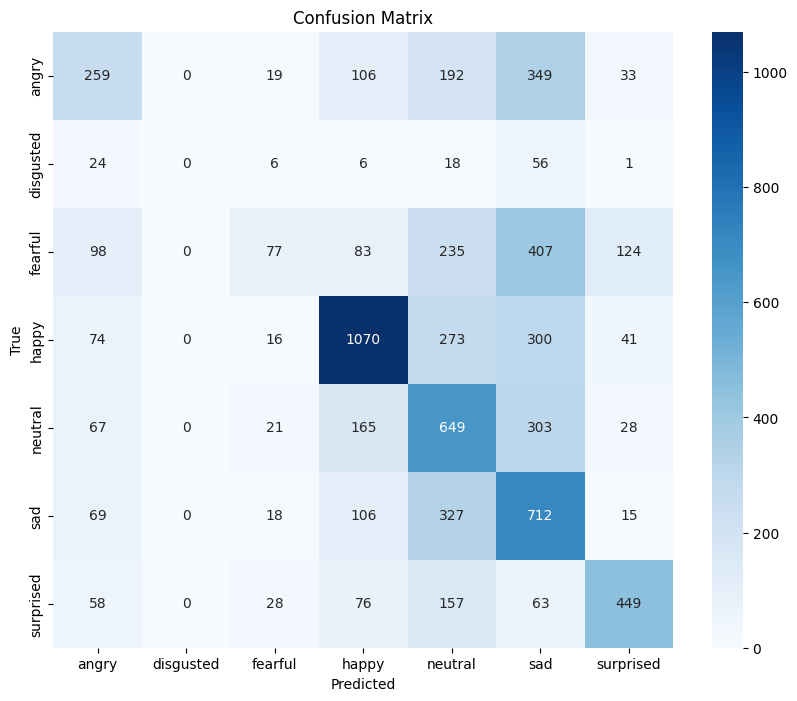

In [19]:
# Print classification report
class_labels = list(train_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [20]:
# Simple prediction function
def predict_emotion(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Simple rescaling
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array, verbose=0)
    emotion = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    return emotion, confidence


In [22]:
# Save the model
model.save('mobilenet_emotion_model.keras', include_optimizer=False)


In [23]:
# Save the model
model.save('mobilenet_emotion_model.keras', include_optimizer=False)

# View the model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        648 │ input_layer_1[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │         96 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        216 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │         96 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        384 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,861,483 (10.92 MB)

 Trainable params: 657,271 (2.51 MB)

 Non-trainable params: 889,664 (3.39 MB)

 Optimizer params: 1,314,548 (5.01 MB)